<a href="https://colab.research.google.com/github/peremartra/Large-Language-Model-Notebooks-Course/blob/main/5-Fine%20Tuning/Prompt_Tuning_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">
<h1><a href="https://github.com/peremartra/Large-Language-Model-Notebooks-Course">LLM Hands On Course</a></h1>
    <h3>Understand And Apply Large Language Models</h3>
    <h2>Introduction to Prompt Tuning using PEFT from Hugging Face.</h2>
    <h3>Fine-tune a Foundational Model effortless</h3>
    <p>by <b>Pere Martra</b></p>
</div>

<br>

<div align="center">
    &nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/pere-martra/"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>
    
</div>

<br>
<hr>

# Prompt Tuning
In this notebook I'm introducing how to apply prompt tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to Prompt Tuning.
Prompt Tuning, or Soft Prompt, is an Additive training Technique. We don't modify the weights of the model, instead we modify the weights of the prompt. To achieve that, we must add some new values to the prompt, and these values are trained. We only modify the weights of the new values in the layers containing the prompt.

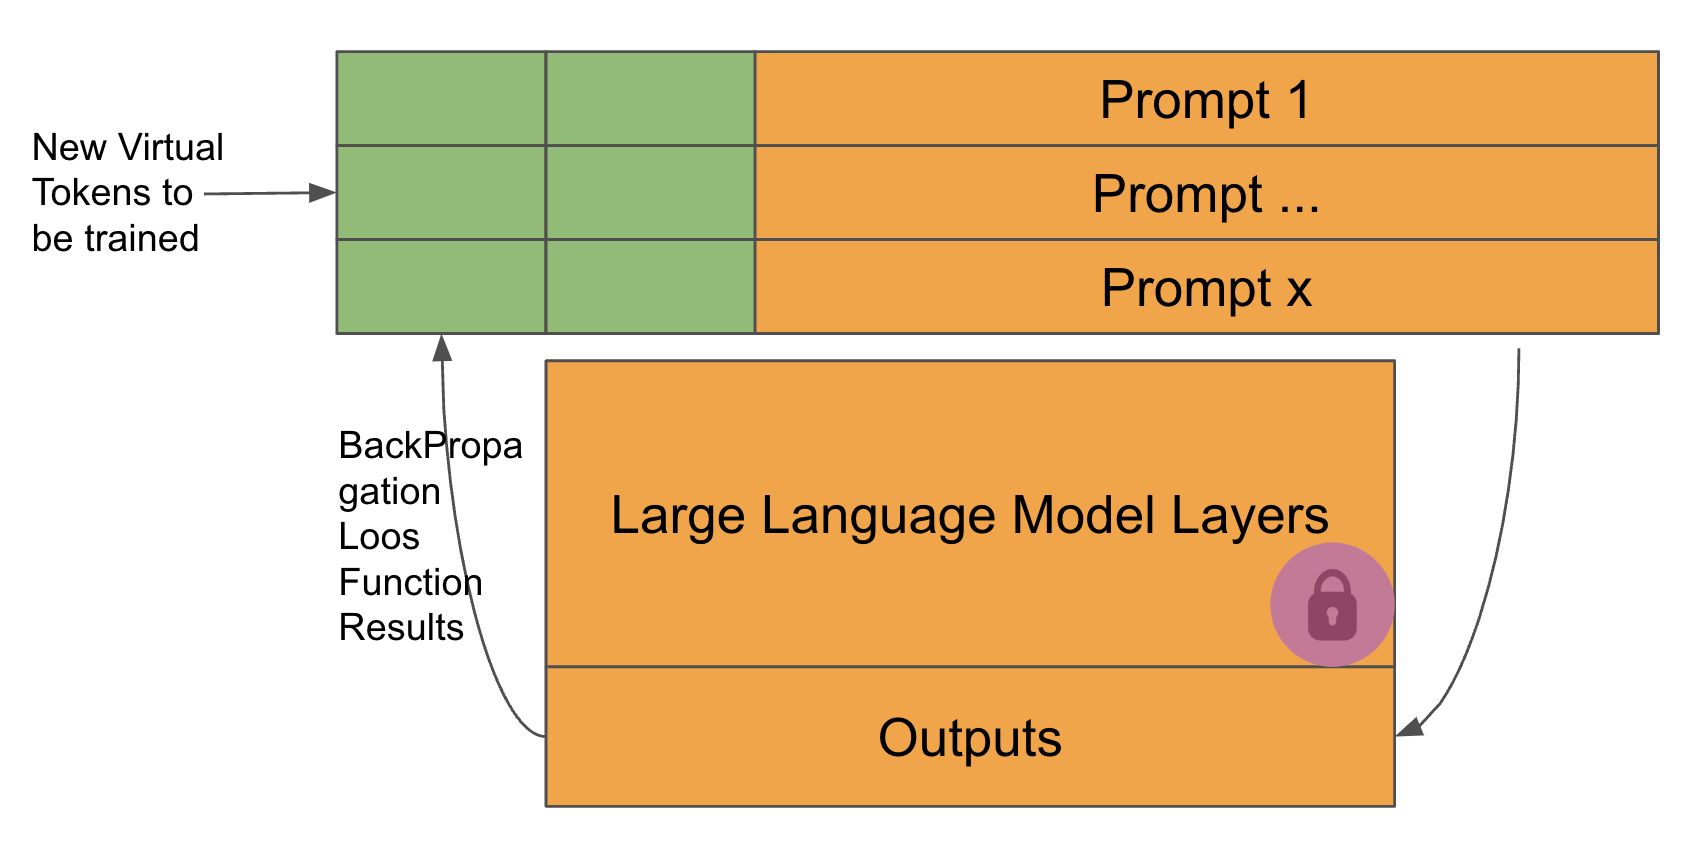

We can modify the behavior of a model by just updating 0.0005% of their weights. Achieving a similar result to other techniques where we update the weights of the model.  

The training is Faster and Cheaper. And not only that, we can train different models and in inference time, we just need to load one foundational model, together with the new small trained models because the weights of the original have not been modified.

## what are we going to do in the notebook
We are going to train two different models using two datasets and just one Pre Trained model from the Bloom family. A model will be trained with a Dataset of prompts and the other with a Dataset of inspirational sentences. We will compare the results to the same question of the models before and after training.

We will see how we can load both models having just one copy of the foundational Model in Memory.


## Load the Peft Library
This library contains the Hugging Face implementation os differente fine-tuning techniques, like Prompt Tuning.

In [3]:
!pip install -q peft==0.8.2

In [4]:
!pip install -q datasets==2.14.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00


From the transformers library we import the necesary classes to import the model and the tokenizer.

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

### Loading the model and the tokenizers.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [6]:
model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 5

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundational_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Inference with the pre trained bloom model

In [8]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100):
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

As we want to have 2 different trained models I will create two diferent prompts.

The first Model will be trained with a Dataset with prompts, and the second one with a Dataset with motivation sentences.  

The first model will recieve the prompt "I want you to act as an English translator, " and the second Model "There two thing that matter:".

But First I'm going to collect some results from the Model without fine-tuning it.

In [9]:
input_prompt = tokenizer("I want you to act as a motivational coach. ", return_tensors="pt")
foundational_outputs_prompt = get_outputs(foundational_model, input_prompt, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_prompt, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


["I want you to act as a motivational coach.  Don't be afraid of being challenged."]


In [10]:
input_sentences = tokenizer("There are two things that matter:", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundational_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['There are two things that matter: the amount of time and money.']


Both answer are more or less correct. Any of the Bloom models is pre-trained and can generate sentences correctly, and with sense. Let's see if after training the reponses are equal or more or less acurated.

## Preparing the Datasets
The Datasets useds are:
* https://huggingface.co/datasets/fka/awesome-chatgpt-prompts
* https://huggingface.co/datasets/Abirate/english_quotes


In [11]:
import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
from datasets import load_dataset

dataset_prompt = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data_prompt = load_dataset(dataset_prompt)
data_prompt = data_prompt.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample_prompt = data_prompt["train"].select(range(50))

#train_sample_prompt = train_sample_prompt.remove_columns('act')

display(train_sample_prompt)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset({
    features: ['act', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [13]:
print(train_sample_prompt[:1])

{'act': ['Linux Terminal'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd'], 'input_ids': [[44, 4026, 1152, 427, 1769, 661, 267, 104105, 28434, 17, 473, 2152, 4105, 49123, 530, 1152, 2152, 57502, 1002, 3595, 368, 28434, 3403, 6460, 17, 473, 4026, 1152, 427, 3804, 57502, 1002, 368, 28434, 10014, 14652, 2592, 19826, 4400, 10973, 15, 530, 16915, 4384, 17, 727, 1130, 11602, 184637, 17, 727, 1130, 4105, 49123, 35262, 473, 32247, 1152, 427, 727, 1427, 17, 3262, 707, 3423, 427, 13485, 1152, 7747, 361, 170205, 15, 707, 2152, 727, 1427, 1331, 55385, 5484, 14652, 6291, 999, 117805, 731, 29726, 1119, 96, 17, 26

In [14]:
dataset_sentences = load_dataset("Abirate/english_quotes")

data_sentences = dataset_sentences.map(lambda samples: tokenizer(samples["quote"]), batched=True)
train_sample_sentences = data_sentences["train"].select(range(25))
train_sample_sentences = train_sample_sentences.remove_columns(['author', 'tags'])
display(train_sample_sentences)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2508 [00:00<?, ? examples/s]

Dataset({
    features: ['quote', 'input_ids', 'attention_mask'],
    num_rows: 25
})

## fine-tuning.  

### PEFT configurations


API docs:
https://huggingface.co/docs/peft/main/en/package_reference/tuners#peft.PromptTuningConfig

We can use the same configuration for both models to be trained.


In [15]:
from peft import  get_peft_model, PromptTuningConfig, TaskType, PromptTuningInit

generation_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM, #This type indicates the model will generate text.
    prompt_tuning_init=PromptTuningInit.RANDOM,  #The added virtual tokens are initializad with random numbers
    num_virtual_tokens=NUM_VIRTUAL_TOKENS, #Number of virtual tokens to be added and trained.
    tokenizer_name_or_path=model_name #The pre-trained model.
)


### Creating two Prompt Tuning Models.
We will create two identical prompt tuning models using the same pre-trained model and the same config.

In [16]:
peft_model_prompt = get_peft_model(foundational_model, generation_config)
print(peft_model_prompt.print_trainable_parameters())

trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None


In [17]:
peft_model_sentences = get_peft_model(foundational_model, generation_config)
print(peft_model_sentences.print_trainable_parameters())

trainable params: 4,096 || all params: 559,218,688 || trainable%: 0.0007324504863471229
None


That's amazing: did you see the reduction in trainable parameters? We are going to train a 0.001% of the paramaters available.

Now we are going to create the training arguments, and we will use the same configuration in both trainings.

In [18]:
from transformers import TrainingArguments
def create_training_arguments(path, learning_rate=0.0035, epochs=6):
    training_args = TrainingArguments(
        output_dir=path, # Where the model predictions and checkpoints will be written
        use_cpu=True, # This is necessary for CPU clusters.
        auto_find_batch_size=True, # Find a suitable batch size that will fit into memory automatically
        learning_rate= learning_rate, # Higher learning rate than full fine-tuning
        num_train_epochs=epochs
    )
    return training_args

In [19]:

import os

working_dir = "./"

#Is best to store the models in separate folders.
#Create the name of the directories where to store the models.
output_directory_prompt =  os.path.join(working_dir, "peft_outputs_prompt")
output_directory_sentences = os.path.join(working_dir, "peft_outputs_sentences")

#Just creating the directoris if not exist.
if not os.path.exists(working_dir):
    os.mkdir(working_dir)
if not os.path.exists(output_directory_prompt):
    os.mkdir(output_directory_prompt)
if not os.path.exists(output_directory_sentences):
    os.mkdir(output_directory_sentences)


We need to indicate the directory containing the model when creating the TrainingArguments.

In [20]:
training_args_prompt = create_training_arguments(output_directory_prompt, 0.003, NUM_EPOCHS)
training_args_sentences = create_training_arguments(output_directory_sentences, 0.003, NUM_EPOCHS)

## Train

We will create the trainer Object, one for each model to train.  

In [21]:
from transformers import Trainer, DataCollatorForLanguageModeling
def create_trainer(model, training_args, train_dataset):
    trainer = Trainer(
        model=model, # We pass in the PEFT version of the foundation model, bloomz-560M
        args=training_args, #The args for the training.
        train_dataset=train_dataset, #The dataset used to tyrain the model.
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) # mlm=False indicates not to use masked language modeling
    )
    return trainer


In [23]:
#Training first model.
trainer_prompt = create_trainer(peft_model_prompt, training_args_prompt, train_sample_prompt)
trainer_prompt.train()

You're using a BloomTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=35, training_loss=3.5634547642299106, metrics={'train_runtime': 534.5949, 'train_samples_per_second': 0.468, 'train_steps_per_second': 0.065, 'total_flos': 50882985099264.0, 'train_loss': 3.5634547642299106, 'epoch': 5.0})

In [24]:
#Training second model.
trainer_sentences = create_trainer(peft_model_sentences, training_args_sentences, train_sample_sentences)
trainer_sentences.train()

Step,Training Loss


TrainOutput(global_step=20, training_loss=4.324613189697265, metrics={'train_runtime': 155.9293, 'train_samples_per_second': 0.802, 'train_steps_per_second': 0.128, 'total_flos': 14801267589120.0, 'train_loss': 4.324613189697265, 'epoch': 5.0})

In less than 10 minutes (CPU time in my M1 Pro) we trained 2 different models, with two different missions with a same foundational model as a base.

## Save models
We are going to save the models. These models are ready to be used, as long as we have the pre-trained model from which they were created in memory.

In [25]:
trainer_prompt.model.save_pretrained(output_directory_prompt)
trainer_sentences.model.save_pretrained(output_directory_sentences)


## Inference

You can load the model from the path that you have saved to before, and ask the model to generate text based on our input before!

In [26]:
from peft import PeftModel

loaded_model_prompt = PeftModel.from_pretrained(foundational_model,
                                         output_directory_prompt,
                                         #device_map='auto',
                                         is_trainable=False)

In [27]:
loaded_model_prompt_outputs = get_outputs(loaded_model_prompt, input_prompt)
print(tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


['I want you to act as a motivational coach.  I will help your team develop their confidence and improve the performance of themselves.']


If we compare both answers something changed.
* ***Pretrained Model:*** *I want you to act as a motivational coach.  Don't be afraid of being challenged.*
* ***Fine Tuned Model:*** *I want you to act as a motivational coach.  You can use this method if you're not sure what your goals are.*

We have to keep in mind that we have only trained the model for a few minutes, but they have been enough to obtain a response closer to what we were looking for.

In [28]:
loaded_model_sentences = PeftModel.from_pretrained(foundational_model,
                                         output_directory_sentences,
                                         #device_map='auto',
                                         is_trainable=False)

In [29]:
loaded_model_sentences_outputs = get_outputs(loaded_model_sentences, input_sentences)
print(tokenizer.batch_decode(loaded_model_sentences_outputs, skip_special_tokens=True))

['There are two things that matter: the weather and your health.']


With the second model we have a similar result.
* **Pretrained Model:** *There two thing that matter: the size and shape of a flower*
* **Fine Tuned Model:** *There two thing that matter: one is the weather and another, what you do.*



# Conclusion
Prompt Tuning is an amazing technique than can save us hours of training and a big amount of money. In the notebook we have trained two models in just few minutes and we can have both models in memory giving service to different clients.

If you want to try different combinations and models the notebook is ready to use another model from the Bloom family.

Yo can change in the third cell the Epochs to train, the num of virtual tokens and the model. But there are a lot of configurations to change, if you want a good exercise can be change the Random initiation of the virtual tokens by a fixed value.

*The responses of the fine Tuned models may be different every time we train the models. I paste the results of one of my trainings but maybe the actuals results are differents.